In [1]:
PROJECT_PATH = '..'
# DATASET_PATH = '/scratch/ceph/dobos/data/pfsspec/train/stellar/grid/bosz_test21'
DATASET_PATH = '/scratch/ceph/dobos/data/pfsspec/train/stellar/grid/bosz'

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
import pandas as pd
from random import sample
from numpy import *
os.environ['PFSSPEC_DATA'] = r'/scratch/ceph/dobos/data/pfsspec'
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')
from pfsspec.stellarmod.boszgrid import BoszGrid
from pfsspec.stellarmod.modelgrid import ModelGrid
from pfsspec.obsmod.spectrum import Spectrum
from scipy.interpolate import interp1d, CubicSpline
# Allow load project as module
#sys.path.insert(0, PROJECT_PATH)
#from pfsspec.data.dataset import Dataset

In [3]:
grid = BoszGrid()
# grid.load(os.path.join(os.environ['PFSSPEC_DATA'], 'import/stellar/grid/bosz/spectra.npz'))
grid.load(os.path.join(os.environ['PFSSPEC_DATA'], 'import/stellar/grid/bosz/spectra.h5'), 'h5')
grid.wave.shape, grid.flux.shape

((16094,), (14, 67, 11, 6, 4, 16094))

In [47]:
grid.wave

array([ 3000.2639,  3000.564 ,  3000.8643, ..., 14996.2119, 14997.7109,
       14999.2109])

In [4]:
grid.flux[0][30][5][3][2]

array([35159000., 35130000., 35082000., ...,   888150.,   887510.,
         886870.])

In [5]:
np.sum(grid.flux_idx)

116614

In [6]:
grid.params

{'Fe_H': <pfsspec.stellarmod.modelparam.ModelParam at 0x7f305c401a58>,
 'T_eff': <pfsspec.stellarmod.modelparam.ModelParam at 0x7f305c401978>,
 'log_g': <pfsspec.stellarmod.modelparam.ModelParam at 0x7f305c4019b0>,
 'C_M': <pfsspec.stellarmod.modelparam.ModelParam at 0x7f305c401cc0>,
 'O_M': <pfsspec.stellarmod.modelparam.ModelParam at 0x7f305c401cf8>}

In [7]:
grid.params['Fe_H'].values

array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
       -0.25,  0.  ,  0.25,  0.5 ,  0.75])

In [8]:
grid.params['T_eff'].values

array([ 3500,  3750,  4000,  4250,  4500,  4750,  5000,  5250,  5500,
        5750,  6000,  6250,  6500,  6750,  7000,  7250,  7500,  7750,
        8000,  8250,  8500,  8750,  9000,  9250,  9500,  9750, 10000,
       10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250,
       12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500,
       17000, 17500, 18000, 18500, 19000, 19500, 20000, 21000, 22000,
       23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000,
       32000, 33000, 34000, 35000])

In [10]:
grid.params['C_M'].values

array([-0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ])

In [9]:
grid.params['O_M'].values

array([-0.25,  0.  ,  0.25,  0.5 ])

## 'Fe_H' = 0.0, 'T_eff' = 3000,'log_g' = 2.0, 'C_M' = 1.0, 'a_Fe' = 0.0

In [12]:
grid.get_nearest_index( Fe_H = 0.0, T_eff = 5000, log_g = 5.0, C_M = 0.0, O_M = 0.0)

(10, 6, 10, 3, 1)

In [55]:
spec = grid.interpolate_model_spline('Fe_H', Fe_H = 0.0, T_eff = 5000, log_g = 2.0, C_M = 0.1, O_M = 0.0)

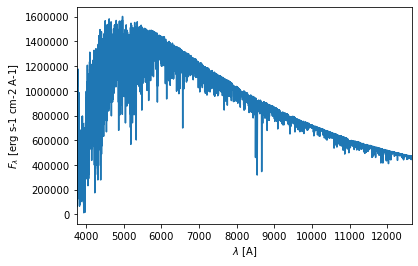

In [57]:
spec.plot()
plt.savefig('spec.svg')

In [ ]:
spec.redshift
rebin to a new grid that matches the subaru grid. 6300-9500 
plot them together. substract. 

resolution of original grid is doube 

In [193]:
flux.shape[1]

16094

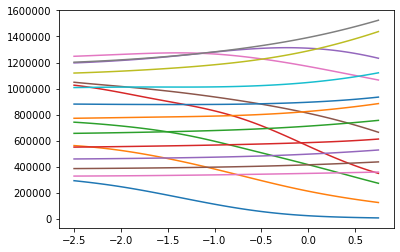

In [238]:
xs = np.linspace(x[0], x[-1], 100)
plt.plot(xs, fn(xs))

In [49]:
def interpolate_model_spline_plot(x,y,fn,wave_idices):
#    free_plt,wave_plt = free_p[plot_idx],waves_sliced[plot_idx]
    f, axs = plt.subplots(4, 4, figsize=(16, 16))
    waveidx = 0
    xs = np.linspace(x[0], x[-1], 100)
    ys = fn(xs)
    for ax in axs.flatten():
        ax.plot(xs, ys[:,waveidx])
        ax.scatter(x,y[:,waveidx],c = 'c')
        ax.title.set_text( 'Wavelength = %.0f' % wave_idices[waveidx])
        waveidx += 1
    return None

In [50]:
def interpolate_model_spline(self, free_param_name, **kwargs):
    list_para = list(self.params.keys())
    if free_param_name not in list_para:
        free_param_name = choice(list_para)

    free_idx = list_para.index(free_param_name)

    # Find nearest model to requested parameters
    idx = list(self.get_nearest_index(**kwargs))
    if idx is None:
        return None

    # Set all params to nearest value except the one in which we interpolate
    for i, p in enumerate(self.params):
        if p != free_param_name:
            kwargs[p] = self.params[p].values[idx[i]]

    # Determine index of models
    idx[free_idx] = slice(None)
    idx = tuple(idx)
    print(idx)
    
    # Find index of models that actually exists
    valid_flux = self.flux_idx[idx]
    print(valid_flux.shape)
    pars = self.params[free_param_name].values[valid_flux]
    print(pars)
    flux = self.flux[idx][valid_flux]
    N_plots, N_wave = 16, flux.shape[1]
    wave_idices = list(range(0,N_wave,int(N_wave//N_plots)))
    flux_16 = flux[:,wave_idices]
    # If we are at the edge of the grid, it might happen that we try to
    # interpolate over zero valid parameters, in this case return None and
    # the calling code will generate another set of random parameters
    if pars.shape[0] < 2:
        return None

    # Do as many parallel cubic spline interpolations as many wavelength bins we have
    x, y = pars, flux_16
    fn = CubicSpline(x, y)
    spec = self.get_parameterized_spec(**kwargs)
    spec.flux = fn(kwargs[free_param_name])

    return spec,x,y,fn,wave_idices

self = grid

# plotting the Fe_H direction

In [51]:
free_param_name = 'Fe_H'
spec,pars,y,fn,wave_idices = interpolate_model_spline(self, free_param_name, Fe_H = 0.0, T_eff = 5000, log_g = 2.0, C_M = 0.0, O_M = 0.0)


(slice(None, None, None), 6, 4, 3, 1)
(14,)
[-2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25
  0.5   0.75]


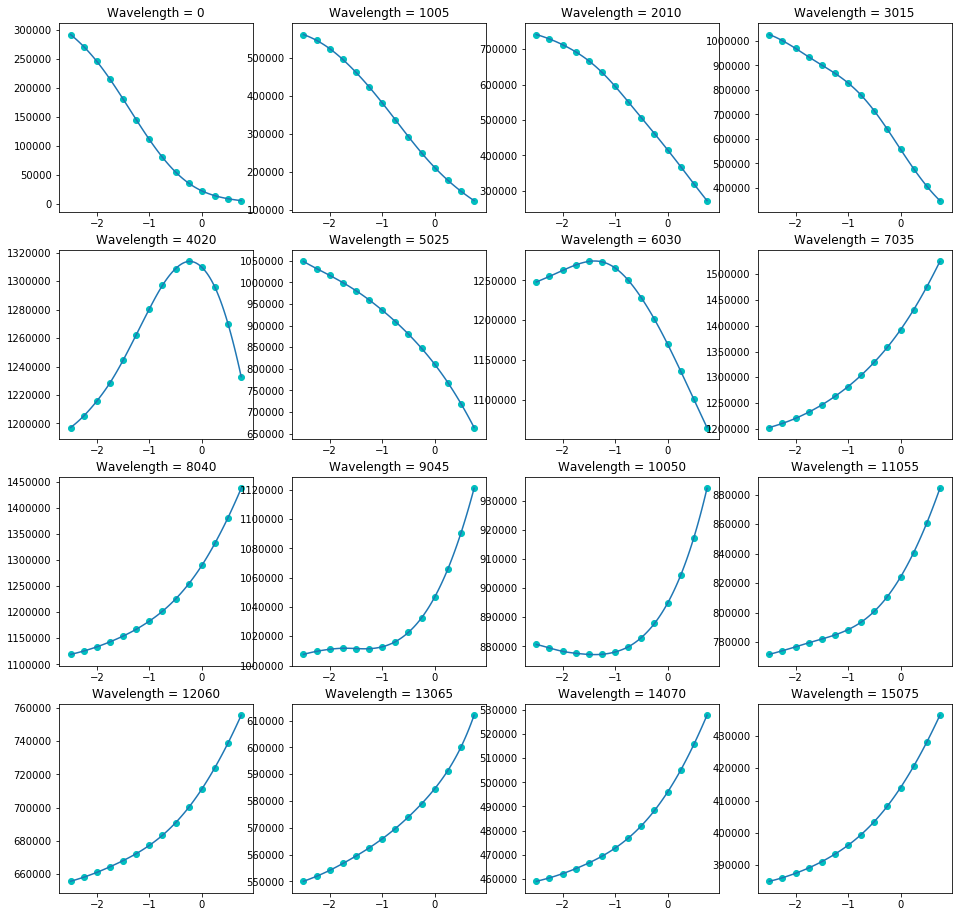

In [52]:
interpolate_model_spline_plot(pars,y,fn,wave_idices)

(10, slice(None, None, None), 4, 3, 1)
(67,)
[ 3500  3750  4000  4250  4500  4750  5000  5250  5500  5750  6000  6250
  6500  6750  7000  7250  7500  7750  8000  8250  8500  8750  9000  9250
  9500  9750 10000 10250 10500 10750 11000 11250 11500 11750 12000]


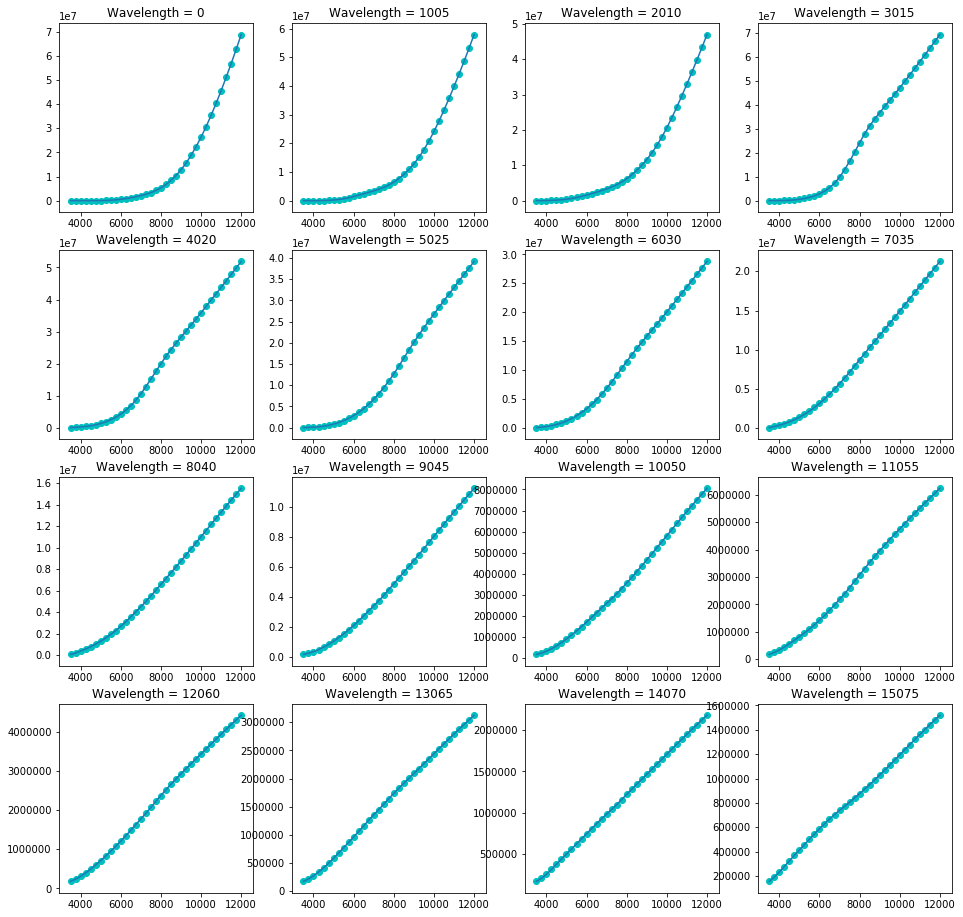

In [44]:
# plotting the T_eff direction
free_param_name= 'T_eff'

spec,pars,y,fn,wave_idices = interpolate_model_spline(self, free_param_name,Fe_H = 0.0, T_eff = 5000, log_g = 2.0, C_M = 0., O_M = 0.0)
interpolate_model_spline_plot(pars,y,fn,wave_idices)


(10, 6, slice(None, None, None), 3, 1)
(11,)
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


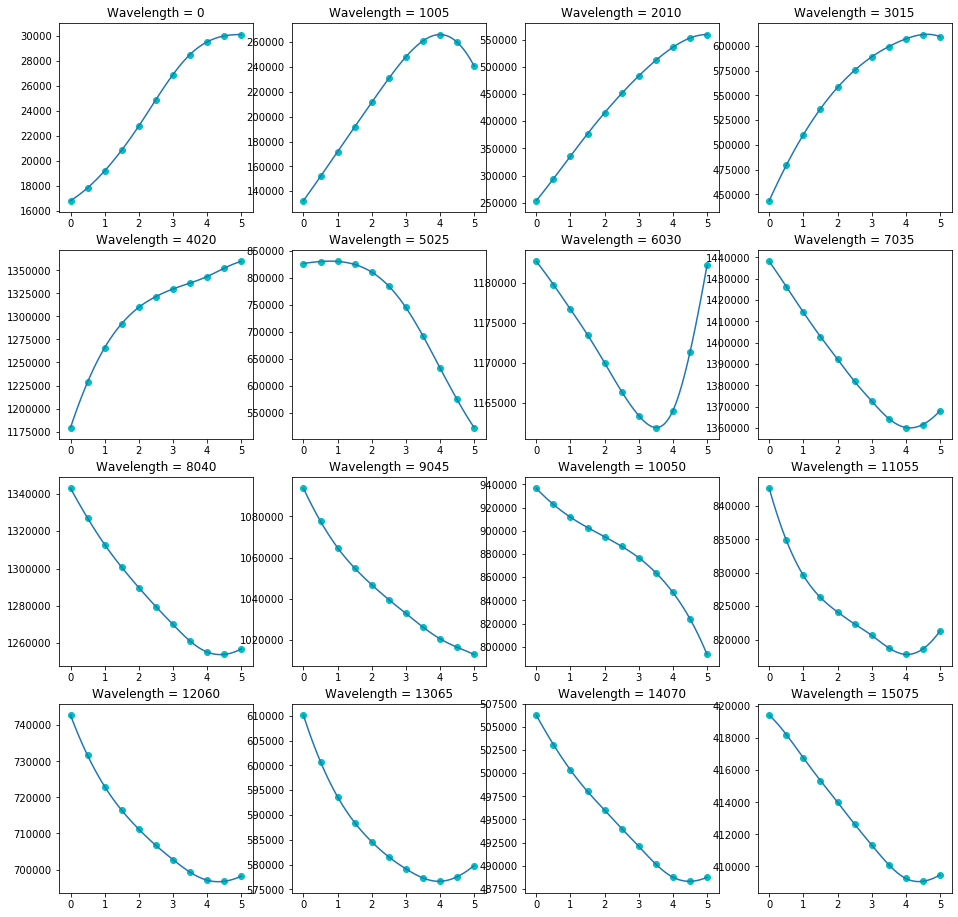

In [43]:
# plotting the log_g direction

free_param_name= 'log_g'
spec,pars,y,fn,wave_idices = interpolate_model_spline(self, free_param_name,Fe_H = 0.0, T_eff = 5000, log_g = 2.0, C_M = 0., O_M = 0.0)
interpolate_model_spline_plot(pars,y,fn,wave_idices)

(10, 6, 4, slice(None, None, None), 1)
(6,)
[-0.5  -0.25  0.    0.25  0.5 ]


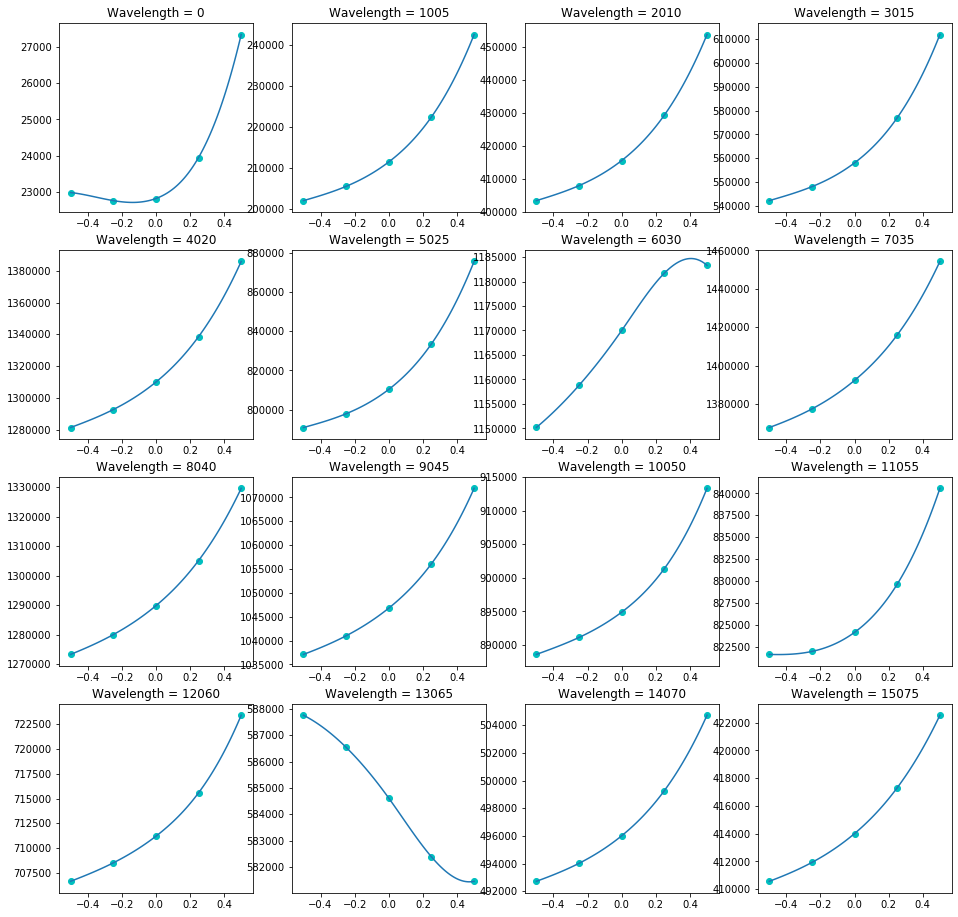

In [42]:
#plotting
free_param_name= 'C_M'
spec,pars,y,fn,wave_idices = interpolate_model_spline(self, free_param_name,Fe_H = 0.0, T_eff = 5000, log_g = 2.0, C_M = 0., O_M = 0.0)
interpolate_model_spline_plot(pars,y,fn,wave_idices)

(10, 6, 4, 3, slice(None, None, None))
(4,)
[-0.25  0.    0.25  0.5 ]


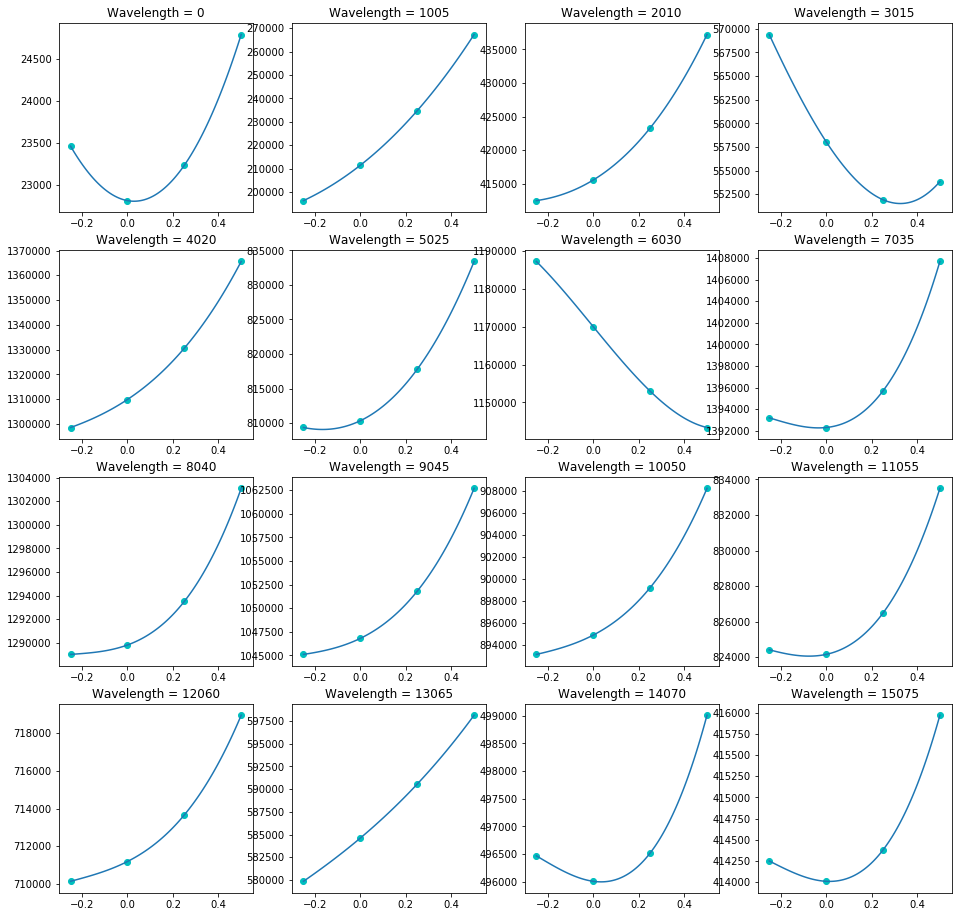

In [53]:
# plotting the O_M direction

free_param_name= 'O_M'
spec,pars,y,fn,wave_idices = interpolate_model_spline(self, free_param_name,Fe_H = 0.0, T_eff = 5000, log_g = 2.0, C_M = 0., O_M = 0.0)
interpolate_model_spline_plot(pars,y,fn,wave_idices)

ValueError: x and y must have same first dimension, but have shapes (16094,) and (17,)

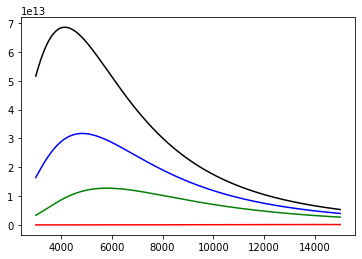

In [275]:
def planck(wav, T):
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity
# generate x-axis in increments from 1nm to 3 micrometer in 1 nm increments
# starting at 1 nm to avoid wav = 0, which would result in division by zero.
wavelengths = spec.wave*1e-10

# intensity at 4000K, 5000K, 6000K, 7000K
intensity4000 = planck(wavelengths, 2000.)
intensity5000 = planck(wavelengths, 5000.)
intensity6000 = planck(wavelengths, 6000.)
intensity7000 = planck(wavelengths, 7000.)


plt.plot(wavelengths*1e10, intensity4000, 'r-') 
# plot intensity4000 versus wavelength in nm as a red line
plt.plot(wavelengths*1e10, intensity5000, 'g-') # 5000K green line
plt.plot(wavelengths*1e10, intensity6000, 'b-') # 6000K blue line
plt.plot(wavelengths*1e10, intensity7000, 'k-') # 7000K black line
plt.plot(wavelengths*1e10, )
# show the plot
plt.show()

cgs

In [267]:
spec.wave

array([ 3000.2639,  3000.564 ,  3000.8643, ..., 14996.2119, 14997.7109,
       14999.2109])

In [161]:
def wave_slice(fluxwave , N_plots = 16):
    # sampling N_plots of wavelengths for ploting
    N_wave = np.shape(fluxwave)[1]
    wave_idices = list(range(0,N_wave+1,int(N_wave//N_plots)))
    # wave_idices: a list of specific wavelength with length = #subplots
    waves_sliced= fluxwave[:,wave_idices]
    return waves_sliced 

def flux_para_plot(plot_idx,waves_sliced,free_p):
    free_plt,wave_plt = free_p[plot_idx],waves_sliced[plot_idx]
    f, axs = plt.subplots(4, 4, figsize=(16, 16))
    waveidx = 0
    for ax in axs.flatten():
        x,y = free_plt,wave_plt[:,waveidx]
        ax.plot(x,y)
        ax.scatter(x,y,c = 'c')
        ax.title.set_text( 'Wavelength = %.0f' % grid.wave[waveidx])
        waveidx += 1
    return None

def flux_para_cubic(plot_idx,waves_sliced,free_p):
    free_plt,wave_plt = free_p[plot_idx],waves_sliced[plot_idx]
    f, axs = plt.subplots(4, 4, figsize=(16, 16))
    waveidx = 0
    for ax in axs.flatten():
        x,y = free_plt,wave_plt[:,waveidx]
        cs = CubicSpline(x,y)
        xs = np.linspace(free_p[0], free_p[-1], 100)
        ax.plot(xs, cs(xs))
        ax.scatter(x,y,c = 'c')
        ax.title.set_text( 'Wavelength = %.0f' % grid.wave[waveidx])
        waveidx += 1
    return None

def para_to_val(free_p):
    freeval = grid.params[free_params_name].values
    return freeval[free_p]

# Plotting

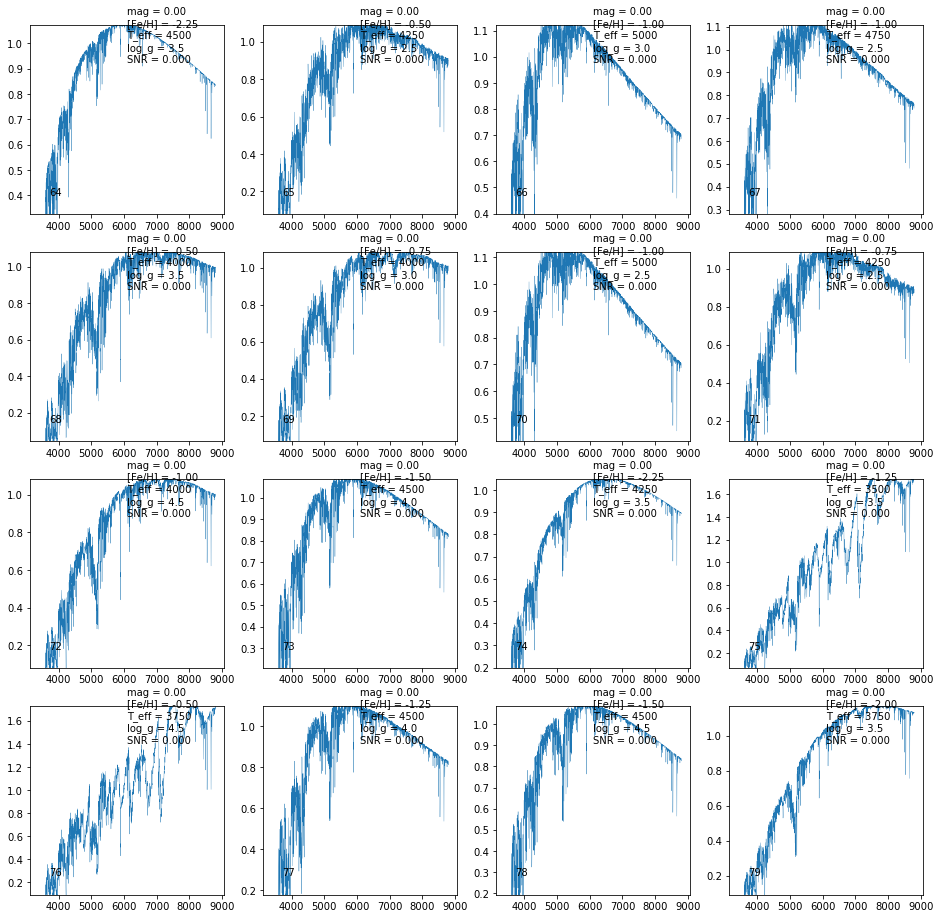

In [67]:
f, axs = plt.subplots(4, 4, figsize=(16, 16))

i = 0
#id = np.random.randint(ds.flux.shape[0] - 16)
id = 64
for ax in axs.flatten():
    idx = np.digitize([4000, 8000], ds.wave)
    mm = np.median(ds.flux[id + i, idx[0]:idx[1]])
    #ax.plot([4000, 12000], [mm, mm])
    
    ax.plot(ds.wave, ds.flux[id + i, :] / mm, lw=0.3)
    mm = np.quantile(ds.flux[id + i, :] / mm, [0.05, 0.95])
    ax.set_ylim(mm[0], mm[1])
    #mm = np.median(ds.flux[id + i, :])
    #ax.set_ylim(-2 * mm, 10 * mm)
    #ax.set_ylim(-1, 3)
    ax.text(0.1, 0.1, str(id + i), transform=ax.transAxes)
    ax.text(0.5, 0.8, 'mag = %.2f \n[Fe/H] = %.2f \nT_eff = %.0f \nlog_g = %.1f \nSNR = %.3f' 
            % (ds.params['mag'][id + i], ds.params['Fe_H'][id + i], ds.params['T_eff'][id + i], ds.params['log_g'][id + i], ds.params['snr'][id + i]), transform=ax.transAxes)
    i += 1
    
plt.savefig(os.path.join(DATASET_PATH, 'examples.png'))

# Training set properties

## Distribution of stellar parameters

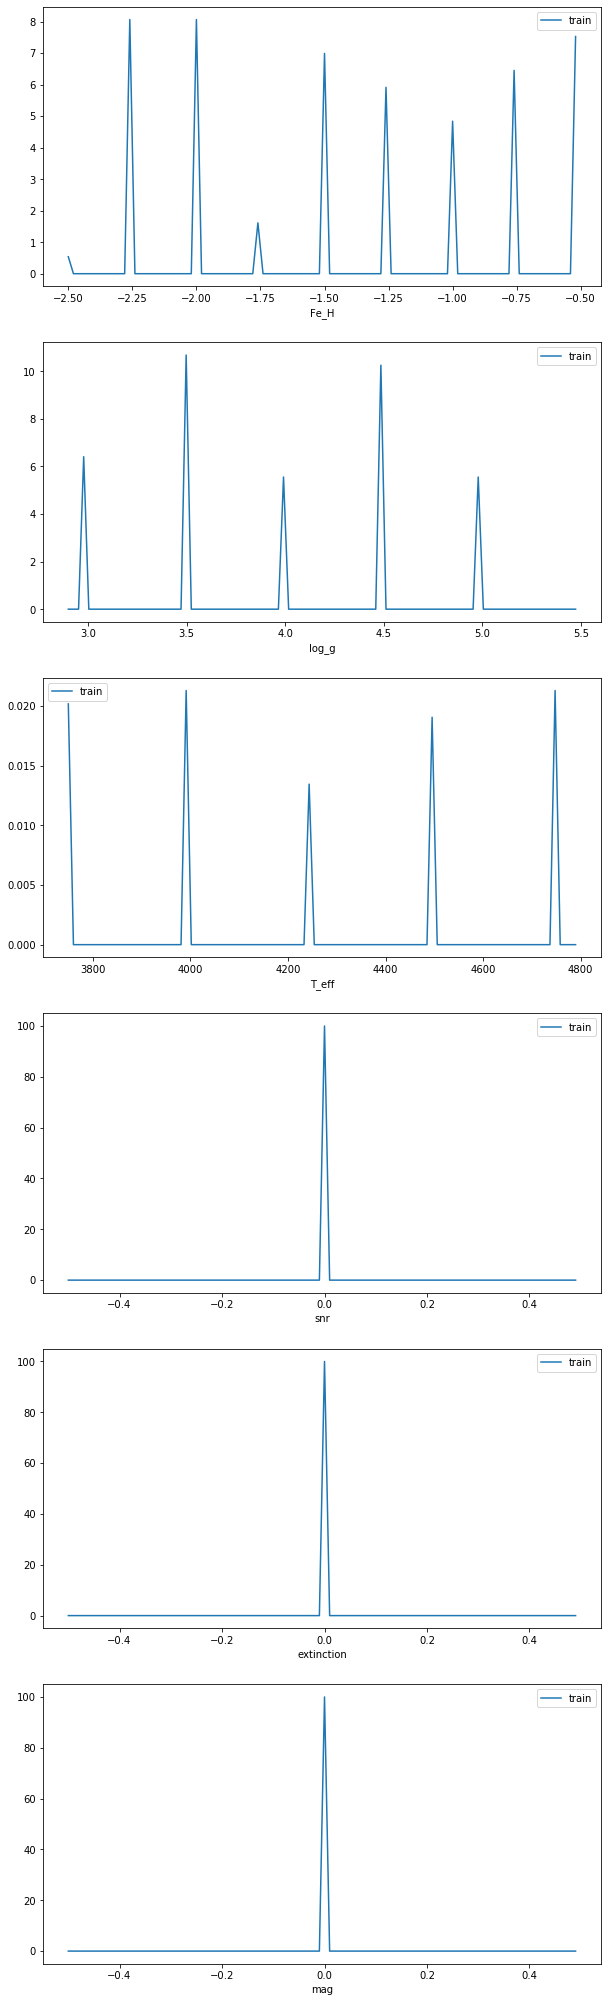

In [68]:
N = len(params)
f, ax = plt.subplots(N, 1, figsize=(10, 6 * N))
i = 0
for k in params:
    qs = np.quantile(ds.params[k], [0.1, 0.2, 0.8, 0.9])
    hist_range = (2 * qs[0] - qs[1], 2 * qs[3] - qs[2])
    hist1, bins = np.histogram(ds.params[k], range=hist_range, bins=100, density=True)
    ax[i].plot(bins[:-1], hist1, '-', label='train')
    ax[i].set_xlabel(k)
    ax[i].legend()
    i += 1
    
plt.savefig(os.path.join(DATASET_PATH, 'params.png'))